In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import arviz as az
from cycler import cycler

from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive, save_figure


CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)

In [2]:
abbreviations = {
    "post_ablation": "post abl.",
}

def format_name(name: str):
    return name.replace("_", " ").capitalize()


In [3]:
# def forestplot(ax, ts, xlabel="Test statistic"):
#     az.plot_forest(ts, ax=ax, combined=True, textsize=12, linewidth=3, hdi_prob=0.95);
#     ax.axvline(0.0, linestyle="--", color="black");
#     xlow, xhigh = ax.get_xlim();
#     xbiggest = max(abs(xlow), abs(xhigh))
#     ax.set_xlim(-xbiggest, xbiggest);
#     ax.set(title="", xlabel=xlabel);
#     return ax

def forestplot(ax, ts, xlabel="Test statistic", qlow=0.025, qhigh=0.975):
    ylimlow, ylimhigh = ax.get_ylim()
    ytickys = np.linspace(ylimlow, ylimhigh, len(ts)+2)
    ys = ytickys[1:-1]
    xlows = [np.quantile(t, qlow) for t in ts.values()]
    xhighs = [np.quantile(t, qhigh) for t in ts.values()]
    xmeans = [np.mean(t) for t in ts.values()]
    xbiggest = max(np.abs(xlows + xhighs)) + 0.1
    ax.set_xlim(-xbiggest, xbiggest)
    for y, xlow, xhigh, xmean in zip(ys, xlows, xhighs, xmeans):
        line = ax.hlines(y=y, xmin=xlow, xmax=xhigh, linewidth=2)
        ax.plot(xmean, y, marker="o", color=line.get_colors()[0])
    ax.set_yticks(ytickys, [""] + list(ts.keys()) + [""])
    # az.plot_forest(ts, ax=ax, combined=True, textsize=12, linewidth=3, hdi_prob=0.95);
    ax.axvline(0.0, linestyle="--", color="black");
    ax.set(title="", xlabel=xlabel);
    ax.tick_params(axis='y', which="both", left=False, right=False)
    return ax

## Whisker stimulation (Figure 2)

In [4]:
whisker_idata = az.InferenceData.from_zarr(os.path.join("..", "inferences", "whisker-ind", "idata"))

Prob: 0.65025


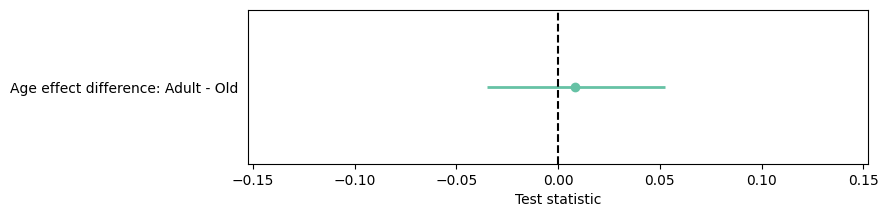

In [5]:
t = whisker_idata.posterior["mu"].sel(age="adult") - whisker_idata.posterior["mu"].sel(age="old")

f, ax = plt.subplots(figsize=[8,2])
forestplot(ax, {"Age effect difference: Adult - Old": t});
save_figure(f, "main-f2-whisker-age")
print("Prob: " + str((t>0).mean().item()))

### Caption for above figure

Thin green line: posterior 94% highest density interval for difference in age effect on whisker stimulation response in our statistical model. Thick green line: posterior 25% and 75% quartiles.
Dot: posterior mean.

These results indicate that, according to our model, there is no clear effect of age on whisker stimulation response. The posterior probability that adults have generally higher response is approximately 65%.


Pr(t>0):
Treatment effect difference: After ablation - After hyper: 0.0
Treatment effect difference: After hyper - Baseline: 0.0


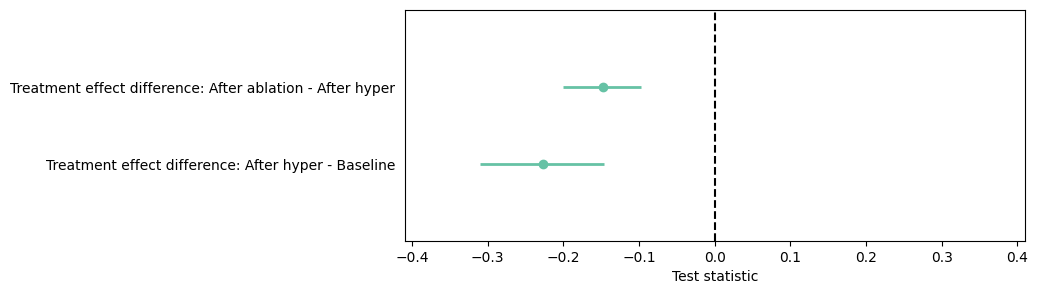

In [6]:
ts = {
    f"Treatment effect difference: {format_name(treatment)} - {format_name(compare)}": (
        whisker_idata.posterior["a_treatment"].sel(treatment=treatment)
        - whisker_idata.posterior["a_treatment"].sel(treatment=compare)
    )
    for treatment, compare in [("after_hyper", "baseline"), ("after_ablation", "after_hyper")]
}
f, ax = plt.subplots(figsize=[8, 3])
forestplot(ax, ts);
save_figure(f, "main-f2-whisker-treatment")

print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

## Hypertensive challenge (figure 3)

In [7]:
hyper_data = load_prepared_data("../data/prepared/hypertension.json")
hyper_idata = az.InferenceData.from_zarr(os.path.join("..", "inferences", "hypertension-basic", "idata"))

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Pr(t>0):
Treatment effect difference: Hyper2 - Hyper1: 1.0
Age effect difference: Adult - Old: 0.0102


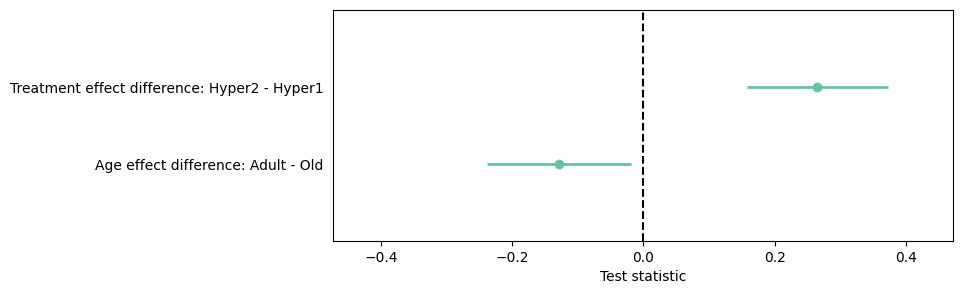

In [8]:
ts = {}
prs = {}

for param_name, coord, (a, b) in zip(
    ["mu", "a_treatment"], 
    ["age", "treatment"],
    [("adult", "old"), ("hyper2", "hyper1")]
):
    t = hyper_idata.posterior[param_name].sel({coord: a}) - hyper_idata.posterior[param_name].sel({coord: b})
    name = f"{coord.capitalize()} effect difference: {a.capitalize()} - {b.capitalize()}"
    ts[name] = t
    prs[name] = (t > 0).mean().values[()]

f, ax = plt.subplots(figsize=[8, 3])
ax = forestplot(ax, ts);
save_figure(f, "main-f3-hypertension")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

Pr(t>0):
Difference in vessel type effect: Cap2 - Pen art: 0.9802
Difference in vessel type effect: Cap1 - Pen art: 0.9575
Difference in vessel type effect: Bulb - Pen art: 0.9958
Difference in vessel type effect: Sphincter - Pen art: 0.987


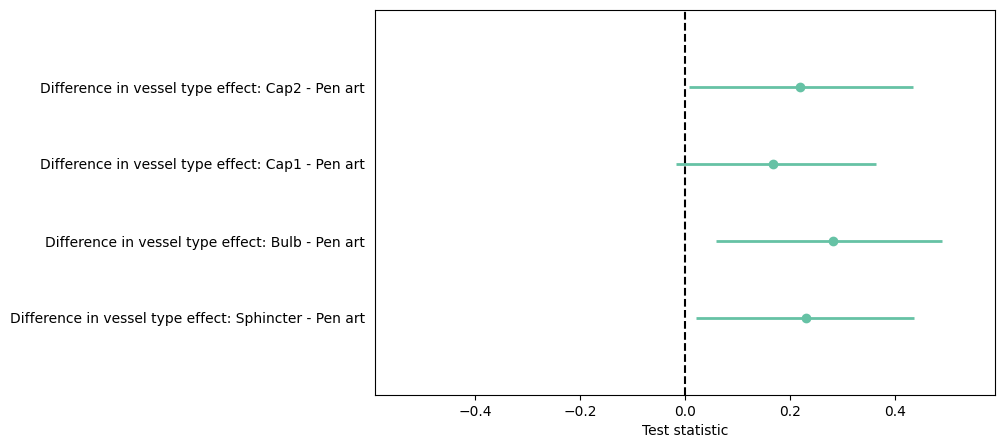

In [9]:
diff = {
    f"Difference in vessel type effect: {format_name(vt)} - {format_name('pen_art')}": (
        hyper_idata.posterior["a_vessel_type"].sel(vessel_type=vt) 
        - hyper_idata.posterior["a_vessel_type"].sel(vessel_type="pa")
    )
    for vt in ["sphincter", "bulb", "cap1", "cap2"]
}
f, ax = plt.subplots(figsize=[8, 5])
forestplot(ax, diff);

save_figure(f, "main-f3-effects-vesseltype")

print("Pr(t>0):")
for name, t in list(diff.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

## RBC flow (figure 4)

In [10]:
idatas_flow = {
    "speed": az.from_zarr(os.path.join("..", "inferences", "flow-basic-speed", "idata")),
    "flux": az.from_zarr(os.path.join("..", "inferences", "flow-basic-flux", "idata"))
}

Pr(t>0):
Treatment effect difference: Hyper2 - After ablation: 1.0
Treatment effect difference: After ablation - After hyper: 0.956
Treatment effect difference: Hyper - Baseline: 1.0
Age effect difference: Adult - Old: 1.0


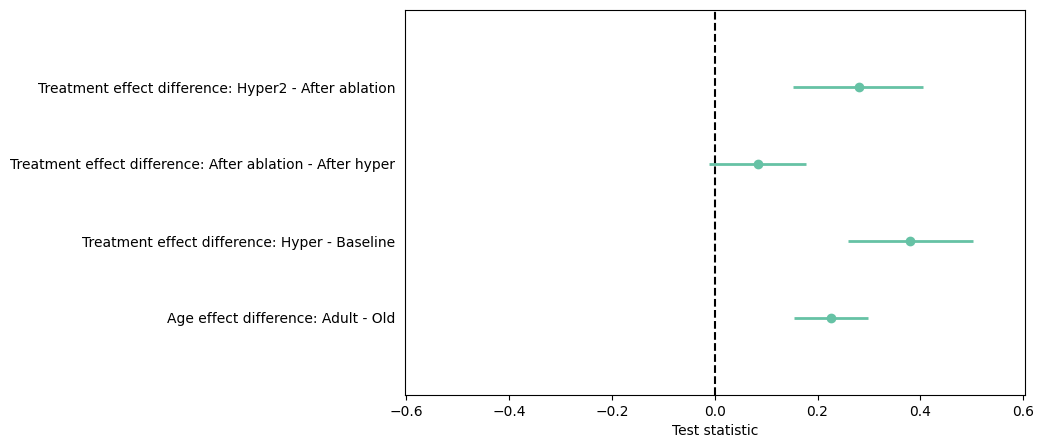

In [11]:
idata = idatas_flow["speed"]

ts_age = {
    f"Age effect difference: Adult - Old": idata.posterior["mu"].sel(age="adult") - idata.posterior["mu"].sel(age="old")
}
ts_treatment = {
    f"Treatment effect difference: {format_name(after)} - {format_name(before)}": (
        idata.posterior["a_treatment"].sel(treatment=after) 
        - idata.posterior["a_treatment"].sel(treatment=before)
    )
    for before, after in [("baseline", "hyper"), ("after_hyper", "after_ablation"), ("after_ablation", "hyper2")]
}
ts = ts_age | ts_treatment

f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)
save_figure(f, "main-f4-flow-velocity")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")


Pr(t>0):
Treatment effect difference: Hyper2 - After ablation: 0.9895
Treatment effect difference: After ablation - After hyper: 0.9605
Treatment effect difference: Hyper - Baseline: 1.0
Age effect difference: Adult - Old: 0.9992


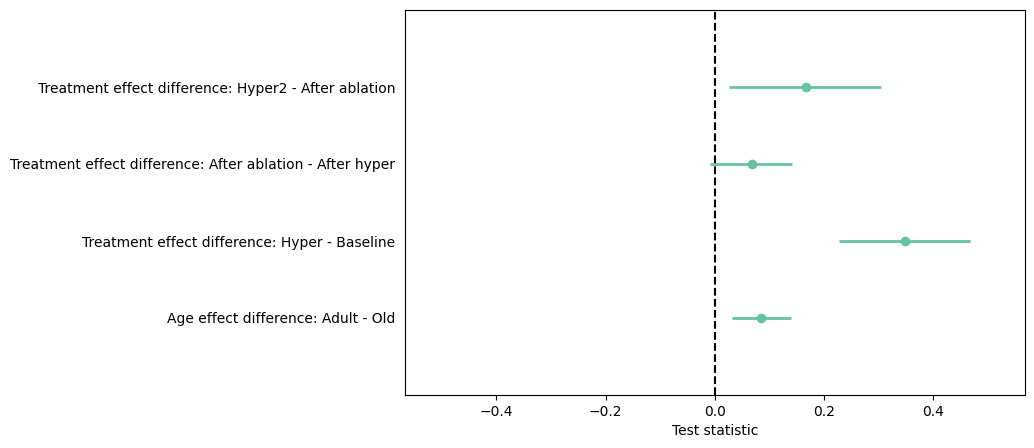

In [12]:
idata = idatas_flow["flux"]

ts_age = {
    f"Age effect difference: Adult - Old": idata.posterior["mu"].sel(age="adult") - idata.posterior["mu"].sel(age="old")
}
ts_treatment = {
    f"Treatment effect difference: {format_name(after)} - {format_name(before)}": (
        idata.posterior["a_treatment"].sel(treatment=after) 
        - idata.posterior["a_treatment"].sel(treatment=before)
    )
    for before, after in [("baseline", "hyper"), ("after_hyper", "after_ablation"), ("after_ablation", "hyper2")]
}
ts = ts_age | ts_treatment

f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)
save_figure(f, "main-f4-flow-flux")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

## Pulsatility (Figure 5)

In [13]:
idata_f5 = az.from_zarr(os.path.join("..", "inferences", "pulsatility-basic-full", "idata"))

Pr(t>0):
Treatment effect difference: Hyper 2 - After ablation: 0.0832
Treatment effect difference: After hyper - baseline: 0.619
Treatment effect difference: Ablation - After hyper: 0.961
Treatment effect difference: Hyper - baseline: 0.9432
Age effect difference: Adult - Old: 1.0


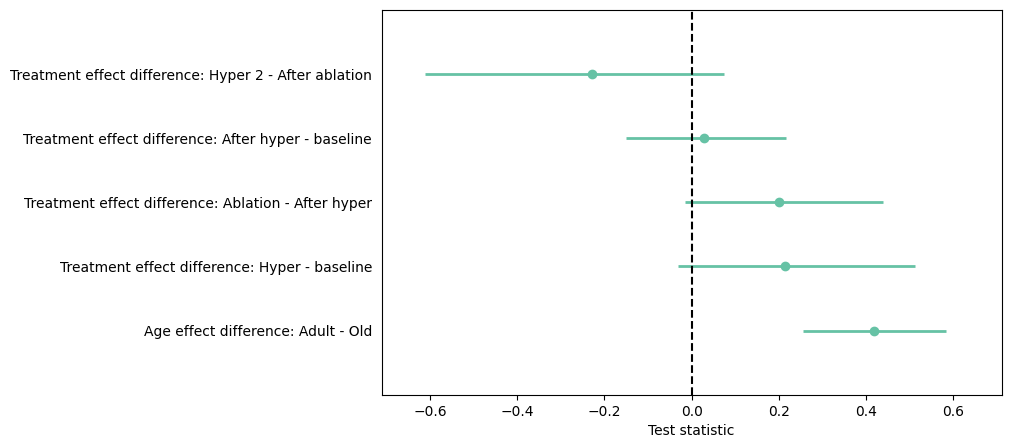

In [14]:
idata = idata_f5
mt = "diameter"

ts_age = {
    f"Age effect difference: Adult - Old": idata.posterior["mu"].sel(age="adult", measurement_type=mt) - idata.posterior["mu"].sel(age="old", measurement_type=mt)
}
ts_hyp_baseline = {
    f"Treatment effect difference: Hyper - baseline": (
        idata.posterior["a_treatment"].sel(treatment="hyper", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="baseline", measurement_type=mt)
    )
}
ts_abl_ahc = {
    f"Treatment effect difference: Ablation - After hyper": (
        idata.posterior["a_treatment"].sel(treatment="after_ablation", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="after_hyper", measurement_type=mt)
    )
}
ts_ahc_baseline = {
    f"Treatment effect difference: After hyper - baseline": (
        idata.posterior["a_treatment"].sel(treatment="after_hyper", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="baseline", measurement_type=mt)
    )
}
ts_h2_aabl = {
    f"Treatment effect difference: Hyper 2 - After ablation": (
        idata.posterior["a_treatment"].sel(treatment="hyper2", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="after_ablation", measurement_type=mt)
    )
}

ts = ts_age | ts_hyp_baseline | ts_abl_ahc | ts_ahc_baseline | ts_h2_aabl


f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)
save_figure(f, "main-f5-pulsatility-diameter")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

Pr(t>0):
Treatment effect difference: Hyper 2 - After ablation: 0.164
Treatment effect difference: After hyper - baseline: 0.7795
Treatment effect difference: Ablation - After hyper: 0.67
Treatment effect difference: Hyper - baseline: 0.7322
Age effect difference: Adult - Old: 0.061


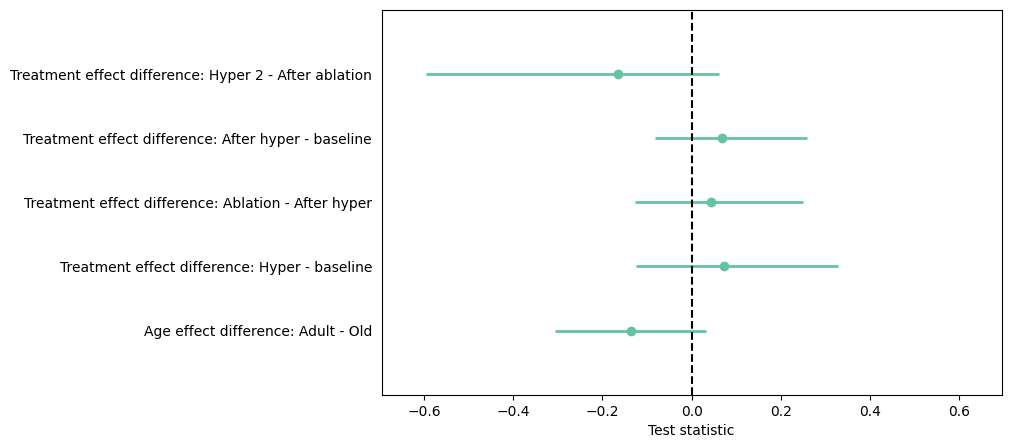

In [15]:
idata = idata_f5
mt = "center"

ts_age = {
    f"Age effect difference: Adult - Old": idata.posterior["mu"].sel(age="adult", measurement_type=mt) - idata.posterior["mu"].sel(age="old", measurement_type=mt)
}
ts_abl_ahc = {
    f"Treatment effect difference: Ablation - After hyper": (
        idata.posterior["a_treatment"].sel(treatment="after_ablation", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="after_hyper", measurement_type=mt)
    )
}
ts_hyp_baseline = {
    f"Treatment effect difference: Hyper - baseline": (
        idata.posterior["a_treatment"].sel(treatment="hyper", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="baseline", measurement_type=mt)
    )
}
ts_ahc_baseline = {
    f"Treatment effect difference: After hyper - baseline": (
        idata.posterior["a_treatment"].sel(treatment="after_hyper", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="baseline", measurement_type=mt)
    )
}
ts_h2_aabl = {
    f"Treatment effect difference: Hyper 2 - After ablation": (
        idata.posterior["a_treatment"].sel(treatment="hyper2", measurement_type=mt) 
        - idata.posterior["a_treatment"].sel(treatment="after_ablation", measurement_type=mt)
    )
}

ts = ts_age | ts_hyp_baseline | ts_abl_ahc | ts_ahc_baseline | ts_h2_aabl

f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)
save_figure(f, "main-f5-pulsatility-center")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

## capillary density (Figure 6)

In [16]:
idata_f6_density = az.InferenceData.from_zarr("../inferences/density/idata")
idata_f6_tortuosity = az.InferenceData.from_zarr("../inferences/tortuosity/idata")
idata_f6_length = az.InferenceData.from_zarr("../inferences/length/idata")
idata_f6_sphincter = az.from_netcdf("../inferences/branchpoints/is_sphincter.nc")
idata_f6_bulb = az.from_netcdf("../inferences/branchpoints/is_bulb.nc")
idata_f6_collatterals = az.from_netcdf("../inferences/collaterals/ctls_per_area.nc")
idata_f6_diameter = az.from_netcdf("../inferences/collaterals/ln_diameter_mean.nc")
idata_f6_collatteral_tortuosity = az.from_netcdf("../inferences/collaterals/ln_m1_tortuosity.nc")
idata_f6_curved_length = az.from_netcdf("../inferences/collaterals/ln_curved_length.nc")
idata_f6_craniotomy_diameter = az.from_netcdf("../inferences/collaterals/ln_craniotomy_diameter.nc")

In [17]:
idata_f6_collatterals

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Pr(t>0):
Age effect difference: Adult - Old (craniotomy diameter): 0.9602
Age effect difference: Adult - Old (collateral curved length): 0.1718
Age effect difference: Adult - Old (collateral tortuosity): 0.1565
Age effect difference: Adult - Old (collateral diameter): 0.3137
Age effect difference: Adult - Old (collateral density): 0.9885


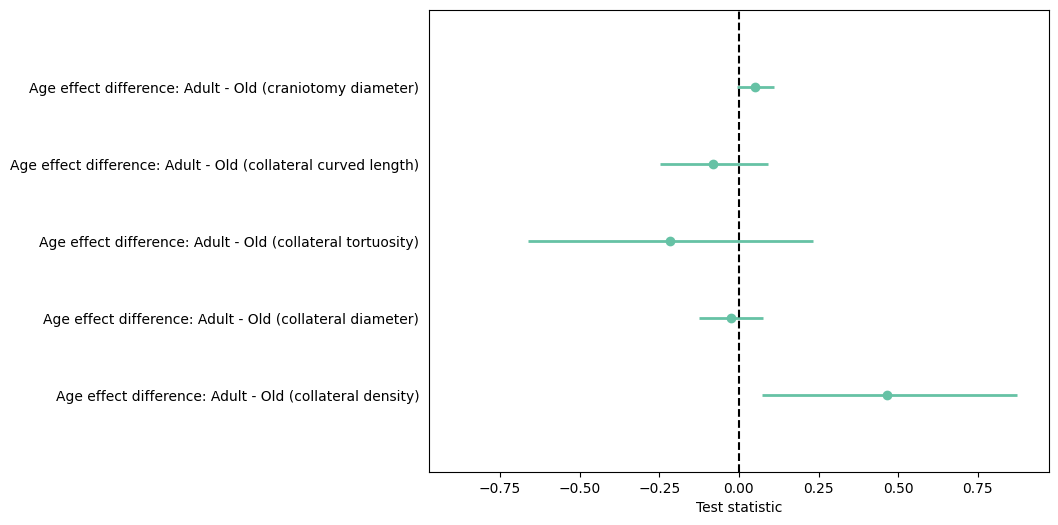

In [18]:
idata = idata_f6_collatterals

ts = {
    "Age effect difference: Adult - Old (collateral density)": (
        -idata_f6_collatterals.posterior["age"]
    ),
    "Age effect difference: Adult - Old (collateral diameter)": (
        -idata_f6_diameter.posterior["age"]
    ),
    "Age effect difference: Adult - Old (collateral tortuosity)": (
        -idata_f6_collatteral_tortuosity.posterior["age"]
    ),
    "Age effect difference: Adult - Old (collateral curved length)": (
        -idata_f6_curved_length.posterior["age"]
    ),
    "Age effect difference: Adult - Old (craniotomy diameter)": (
        -idata_f6_craniotomy_diameter.posterior["age"]
    ),  
}
f, ax = plt.subplots(figsize=[8, 6])
ax = forestplot(ax, ts)


save_figure(f, "main-f6-collaterals-age")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

Pr(t>0):
Age effect difference: Adult - Old (cap12): 0.0142
Age effect difference: Adult - Old (cap11): 0.0145
Age effect difference: Adult - Old (cap10): 0.0558
Age effect difference: Adult - Old (cap9): 0.128
Age effect difference: Adult - Old (cap8): 0.4505
Age effect difference: Adult - Old (cap7): 0.838
Age effect difference: Adult - Old (cap6): 0.8818
Age effect difference: Adult - Old (cap5): 0.979
Age effect difference: Adult - Old (cap4): 0.9715
Age effect difference: Adult - Old (cap3): 0.9788
Age effect difference: Adult - Old (cap2): 0.9852
Age effect difference: Adult - Old (cap1): 0.905


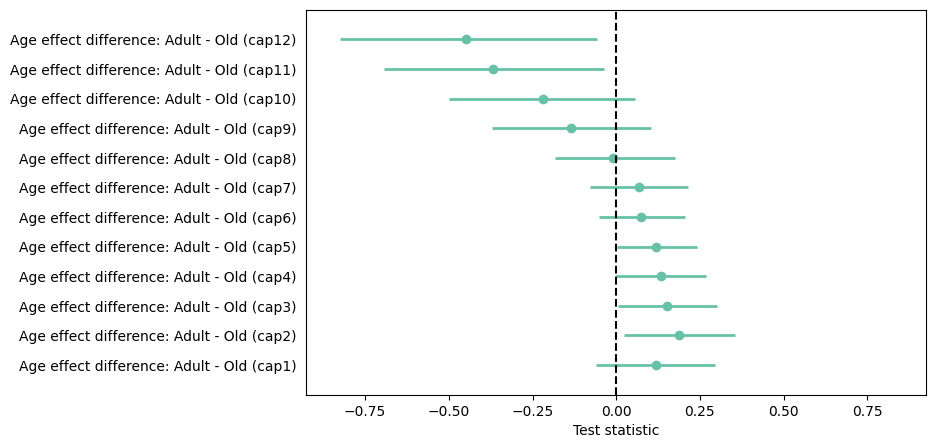

In [19]:
idata = idata_f6_density

ts = {
    f"Age effect difference: Adult - Old ({vt})": (
        idata.posterior["a_age_vessel_type"].sel(age="adult", vessel_type=vt)
        - idata.posterior["a_age_vessel_type"].sel(age="old", vessel_type=vt)
    )
    for vt in idata.posterior.coords["vessel_type"].values
}
f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)


save_figure(f, "main-f6-density-age-vt")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

Pr(t>0):
Age effect difference: Adult - Old (pial_vein): 0.6162
Age effect difference: Adult - Old (av): 0.6982
Age effect difference: Adult - Old (cap12): 0.414
Age effect difference: Adult - Old (cap11): 0.1885
Age effect difference: Adult - Old (cap10): 0.419
Age effect difference: Adult - Old (cap9): 0.37
Age effect difference: Adult - Old (cap8): 0.8205
Age effect difference: Adult - Old (cap7): 0.5375
Age effect difference: Adult - Old (cap6): 0.2515
Age effect difference: Adult - Old (cap5): 0.158
Age effect difference: Adult - Old (cap4): 0.3718
Age effect difference: Adult - Old (cap3): 0.7322
Age effect difference: Adult - Old (cap2): 0.6838
Age effect difference: Adult - Old (cap1): 0.5792
Age effect difference: Adult - Old (pa): 0.0088
Age effect difference: Adult - Old (pial_artery): 0.022


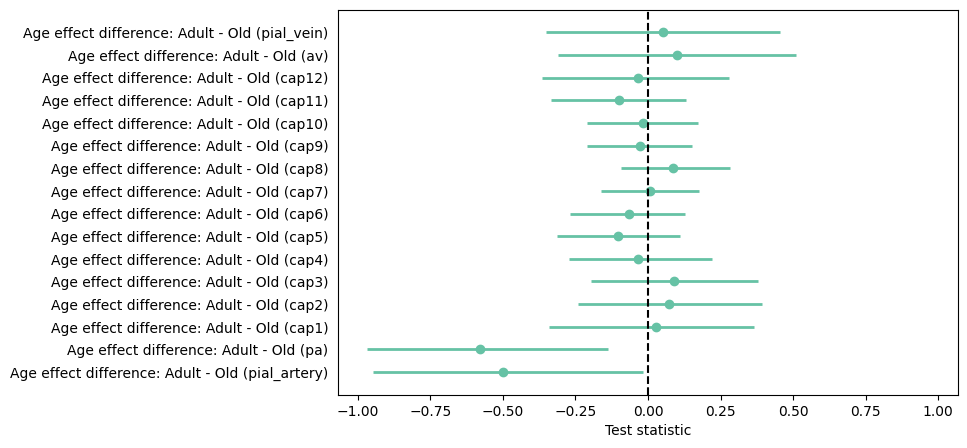

In [20]:
idata = idata_f6_tortuosity

ts = {
    f"Age effect difference: Adult - Old ({vt})": (
        idata.posterior["a_age_vessel_type"].sel(age="adult", vessel_type=vt)
        - idata.posterior["a_age_vessel_type"].sel(age="old", vessel_type=vt)
    )
    for vt in idata.posterior.coords["vessel_type"].values
}
f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)


save_figure(f, "main-f6-tortuosity-age-vt")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

Pr(t>0):
Age effect difference: Adult - Old (pial_vein): 0.7232
Age effect difference: Adult - Old (av): 0.8232
Age effect difference: Adult - Old (cap12): 0.866
Age effect difference: Adult - Old (cap11): 0.833
Age effect difference: Adult - Old (cap10): 0.9052
Age effect difference: Adult - Old (cap9): 0.8785
Age effect difference: Adult - Old (cap8): 0.9362
Age effect difference: Adult - Old (cap7): 0.959
Age effect difference: Adult - Old (cap6): 0.817
Age effect difference: Adult - Old (cap5): 0.718
Age effect difference: Adult - Old (cap4): 0.8105
Age effect difference: Adult - Old (cap3): 0.6617
Age effect difference: Adult - Old (cap2): 0.828
Age effect difference: Adult - Old (cap1): 0.6242
Age effect difference: Adult - Old (pa): 0.0472
Age effect difference: Adult - Old (pial_artery): 0.0008


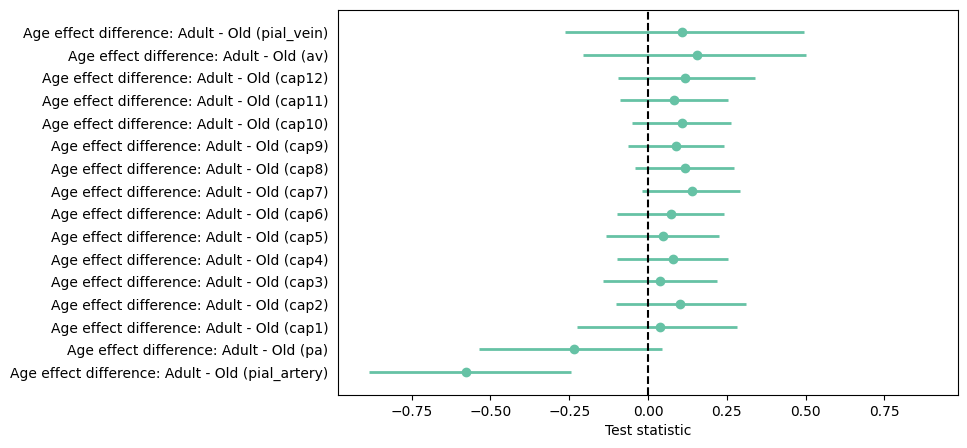

In [21]:
idata = idata_f6_length

ts = {
    f"Age effect difference: Adult - Old ({vt})": (
        idata.posterior["a_age_vessel_type"].sel(age="adult", vessel_type=vt)
        - idata.posterior["a_age_vessel_type"].sel(age="old", vessel_type=vt)
    )
    for vt in idata.posterior.coords["vessel_type"].values
}
f, ax = plt.subplots(figsize=[8, 5])
ax = forestplot(ax, ts)

save_figure(f, "main-f6-length-age-vt")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")

Pr(t>0):
Age effect difference: Adult - Old (bulb): 0.0
Age effect difference: Adult - Old (sphincter): 0.5578


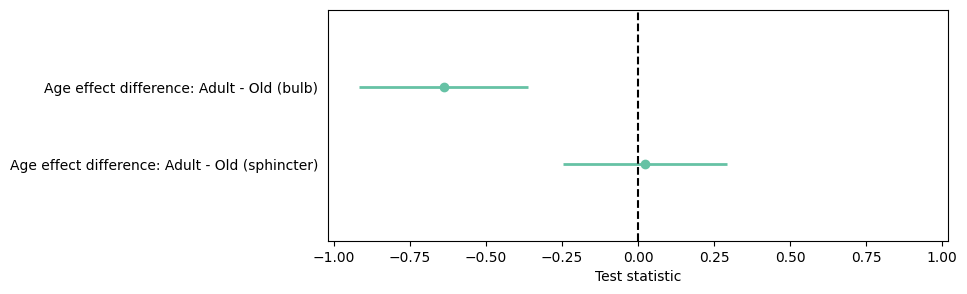

In [22]:
ts = {
    "Age effect difference: Adult - Old (sphincter)": -idata_f6_sphincter.posterior["age"],
    "Age effect difference: Adult - Old (bulb)": -idata_f6_bulb.posterior["age"],
}

f, ax = plt.subplots(figsize=[8, 3])
forestplot(ax, ts);
save_figure(f, "main-f6-sphincter-and-bulb")
print("Pr(t>0):")
for name, t in list(ts.items())[::-1]:
    pr = (t > 0).mean().item()
    print(f"{name}: {np.round(pr, 4)}")